# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [8]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os
import numpy as np

In [9]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [10]:
os.environ["HOPSWORKS_API_KEY"] = "c360klTVehII8xXY.u3NgrKOFiZgjt7SoRKxdWLivKdWkO13v87yBjmGvtdI69MBbCP6mYfKiVGbtsU2I"

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169561
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [11]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [12]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=9,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [13]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.3044643E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [14]:
import pytz

weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

one_day_ago = today - datetime.timedelta(days = 1)
one_day_ago = one_day_ago.replace(hour=0, minute=0, second=0, microsecond=0)

two_day_ago = today - datetime.timedelta(days = 2)
two_day_ago = two_day_ago.replace(hour=0, minute=0, second=0, microsecond=0)

three_day_ago = today - datetime.timedelta(days = 3)
three_day_ago = three_day_ago.replace(hour=0, minute=0, second=0, microsecond=0)

tomorrow_clean = tomorrow.replace(hour=0, minute=0, second=0, microsecond=0)
tomorrow_clean_utc = pytz.timezone('UTC').localize(tomorrow_clean)

today_clean = today.replace(hour=0, minute=0, second=0, microsecond=0)
today_clean_utc = pytz.timezone('UTC').localize(today_clean)

weather_data = weather_fg.filter(weather_fg.date >= today).read()
#air_quality_data = air_quality_fg.filter(air_quality_fg.date == one_day_ago).read()
air_quality_data = air_quality_fg.read()
print(air_quality_data)

batch_data = weather_fg.filter(weather_fg.date >= today).read()


batch_data["pm25_one_day_ago"] = 0
batch_data["pm25_two_day_ago"] = 0
batch_data["pm25_three_day_ago"] = 0

one_day_ago_utc = pytz.timezone('UTC').localize(one_day_ago)

print(print(air_quality_data.loc[air_quality_data['date'] == one_day_ago_utc, 'pm25'].values))

batch_data.loc[batch_data['date'] == tomorrow_clean_utc, 'pm25_one_day_ago'] = air_quality_data.loc[air_quality_data['date'] == today_clean_utc, 'pm25'].values
batch_data.loc[batch_data['date'] == tomorrow_clean_utc, 'pm25_two_day_ago'] = air_quality_data.loc[air_quality_data['date'] == one_day_ago_utc, 'pm25'].values
batch_data.loc[batch_data['date'] == tomorrow_clean_utc, 'pm25_three_day_ago'] = air_quality_data.loc[air_quality_data['date'] == one_day_ago_utc, 'pm25_one_day_ago'].values


batch_data.sort_values(by='date', ascending=True, inplace=True)
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.75s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 
                          date  pm25  pm25_one_day_ago  pm25_two_day_ago  \
0    2014-10-03 00:00:00+00:00  61.0              58.0              69.0   
1    2018-06-09 00:00:00+00:00  51.0              42.0              38.0   
2    2015-07-07 00:00:00+00:00  33.0              29.0              68.0   
3    2023-03-15 00:00:00+00:00  13.0              19.0              43.0   
4    2014-10-07 00:00:00+00:00  42.0              73.0              84.0   
...                        ...   ...               ...               ...   
2269 2024-11-15 00:00:00+00:00  61.0              65.0              53.0   
2270 2024-11-18 00:00:00+00:00   5.0              59.0              37.0   
2271 2024-11-17 00:00:00+00:00  59.0              37.0              61.0   
2272 2024-11-19 00:00:00+00:00   5.0               5.0              

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_one_day_ago,pm25_two_day_ago,pm25_three_day_ago
5,2024-11-21 00:00:00+00:00,2.65,0.0,11.966954,223.781204,rheinlandpfalz,5,5,5
0,2024-11-22 00:00:00+00:00,3.00,0.0,22.473343,234.782318,rheinlandpfalz,0,0,0
4,2024-11-23 00:00:00+00:00,4.60,0.0,14.512064,203.385239,rheinlandpfalz,0,0,0
6,2024-11-24 00:00:00+00:00,15.35,0.0,15.790833,204.227737,rheinlandpfalz,0,0,0
1,2024-11-25 00:00:00+00:00,12.10,0.0,5.483356,113.198624,rheinlandpfalz,0,0,0
2,2024-11-26 00:00:00+00:00,11.05,0.0,17.848160,228.270584,rheinlandpfalz,0,0,0
3,2024-11-27 00:00:00+00:00,9.00,0.0,15.175612,247.693741,rheinlandpfalz,0,0,0
7,2024-11-28 00:00:00+00:00,5.80,0.0,2.099143,120.963692,rheinlandpfalz,0,0,0
8,2024-11-29 00:00:00+00:00,6.45,0.3,8.280000,180.000000,rheinlandpfalz,0,0,0


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [15]:
batch_data["pm_25"] = 0
batch_data = batch_data.drop(columns=["city"])


In [16]:
batch_data.index = range(len(batch_data.index))

In [17]:
#batch_data = batch_data.set_index("date")
for index, row in batch_data.iterrows():
    batch_data.loc[index,'pm_25'] = retrieved_xgboost_model.predict(row.drop(["pm_25", "date"]).values.reshape(1, -1))
    batch_data.loc[index+1, 'pm25_one_day_ago'] = batch_data.loc[index,'pm_25']
    batch_data.loc[index+1, 'pm25_two_day_ago'] = batch_data.loc[index,'pm25_one_day_ago']
    batch_data.loc[index+1, 'pm25_three_day_ago'] = batch_data.loc[index,'pm25_two_day_ago']


batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['pm25_one_day_ago', 'pm25_two_day_ago', 'pm25_three_day_ago', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])


2024-11-20 11:58:39,182 WARNING: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '55.10416030883789' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

2024-11-20 11:58:39,184 WARNING: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '55.10416030883789' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

2024-11-20 11:58:39,186 WARNING: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '55.10416030883789' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

2024-11-20 11:58:39,190 WARNING: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '55.10416030883789' has dtype incompatible with int64, please explicitly cas

In [18]:
batch_data = batch_data.dropna()
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   pm25_one_day_ago             9 non-null      float64            
 6   pm25_two_day_ago             9 non-null      float64            
 7   pm25_three_day_ago           9 non-null      float64            
 8   pm_25                        9 non-null      float64            
 9   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), float64(4)
memory us

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [19]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,pm25_one_day_ago,pm25_two_day_ago,pm25_three_day_ago,pm_25,predicted_pm25,street,city,country,days_before_forecast_day
0,2024-11-21 00:00:00+00:00,2.65,0.0,11.966954,223.781204,5.000000,5.000000,5.000000,55.104160,39.387188,Mainz-Parcusstraße,rheinlandpfalz,germany,1
1,2024-11-22 00:00:00+00:00,3.00,0.0,22.473343,234.782318,55.104160,5.000000,5.000000,47.532356,34.277351,Mainz-Parcusstraße,rheinlandpfalz,germany,2
2,2024-11-23 00:00:00+00:00,4.60,0.0,14.512064,203.385239,47.532356,55.104160,5.000000,49.947010,62.464680,Mainz-Parcusstraße,rheinlandpfalz,germany,3
3,2024-11-24 00:00:00+00:00,15.35,0.0,15.790833,204.227737,49.947010,47.532356,55.104160,51.250309,48.062805,Mainz-Parcusstraße,rheinlandpfalz,germany,4
4,2024-11-25 00:00:00+00:00,12.10,0.0,5.483356,113.198624,51.250309,49.947010,47.532356,40.774456,58.211357,Mainz-Parcusstraße,rheinlandpfalz,germany,5
5,2024-11-26 00:00:00+00:00,11.05,0.0,17.848160,228.270584,40.774456,51.250309,49.947010,47.983475,30.252264,Mainz-Parcusstraße,rheinlandpfalz,germany,6
6,2024-11-27 00:00:00+00:00,9.00,0.0,15.175612,247.693741,47.983475,40.774456,51.250309,50.450344,42.101608,Mainz-Parcusstraße,rheinlandpfalz,germany,7
7,2024-11-28 00:00:00+00:00,5.80,0.0,2.099143,120.963692,50.450344,47.983475,40.774456,43.552395,78.915794,Mainz-Parcusstraße,rheinlandpfalz,germany,8
8,2024-11-29 00:00:00+00:00,6.45,0.3,8.280000,180.000000,43.552395,50.450344,47.983475,49.288456,57.380100,Mainz-Parcusstraße,rheinlandpfalz,germany,9


In [20]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 0 to 8
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   pm25_one_day_ago             9 non-null      float64            
 6   pm25_two_day_ago             9 non-null      float64            
 7   pm25_three_day_ago           9 non-null      float64            
 8   pm_25                        9 non-null      float64            
 9   predicted_pm25               9 non-null      float32            
 10  street                       9 non-null      object        

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-20 11:58:39,320 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



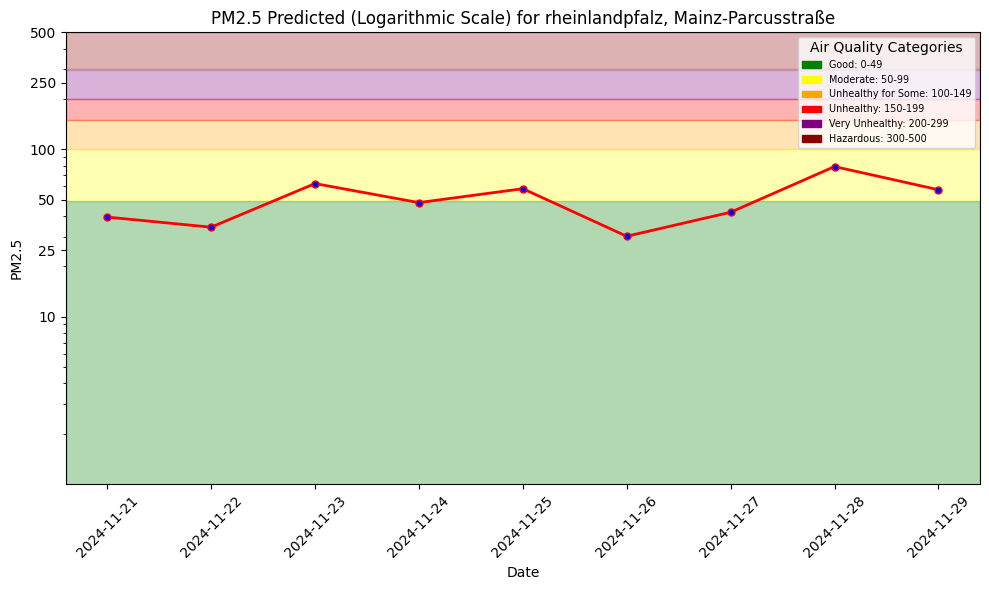

In [21]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [22]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [23]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1169561/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1edd3f37d60>, None)

In [24]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.85s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,pm25_one_day_ago,pm25_two_day_ago,pm25_three_day_ago,pm_25,predicted_pm25,street,city,country,days_before_forecast_day
0,2024-11-20 00:00:00+00:00,5.25,0.0,20.633371,263.991089,5.0,5.0,59.0,48.547699,16.569653,Mainz-Parcusstraße,rheinlandpfalz,germany,1
1,2024-11-21 00:00:00+00:00,2.65,0.0,11.966954,223.781204,5.0,5.0,5.0,55.104160,39.387188,Mainz-Parcusstraße,rheinlandpfalz,germany,1


In [25]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.55s) 


,date,pm25,pm25_one_day_ago,pm25_two_day_ago,pm25_three_day_ago,country,city,street,url
0,2014-10-03 00:00:00+00:00,61.0,58.0,69.0,18.0,germany,rheinlandpfalz,Mainz-Parcusstraße,https://api.waqi.info/feed/@6135
1,2018-06-09 00:00:00+00:00,51.0,42.0,38.0,32.0,germany,rheinlandpfalz,Mainz-Parcusstraße,https://api.waqi.info/feed/@6135
2,2015-07-07 00:00:00+00:00,33.0,29.0,68.0,78.0,germany,rheinlandpfalz,Mainz-Parcusstraße,https://api.waqi.info/feed/@6135
3,2023-03-15 00:00:00+00:00,13.0,19.0,43.0,57.0,germany,rheinlandpfalz,Mainz-Parcusstraße,https://api.waqi.info/feed/@6135
4,2014-10-07 00:00:00+00:00,42.0,73.0,84.0,65.0,germany,rheinlandpfalz,Mainz-Parcusstraße,https://api.waqi.info/feed/@6135
...,...,...,...,...,...,...,...,...,...
2269,2024-11-15 00:00:00+00:00,61.0,65.0,53.0,68.0,germany,rheinlandpfalz,Mainz-Parcusstraße,https://api.waqi.info/feed/@6135
2270,2024-11-18 00:00:00+00:00,5.0,59.0,37.0,61.0,germany,rheinlandpfalz,Mainz-Parcusstraße,https://api.waqi.info/feed/@6135
2271,2024-11-17 00:00:00+00:00,59.0,37.0,61.0,65.0,germany,rheinlandpfalz,Mainz-Parcusstraße,https://api.waqi.info/feed/@6135
2272,2024-11-19 00:00:00+00:00,5.0,5.0,59.0,37.0,germany,rheinlandpfalz,Mainz-Parcusstraße,https://api.waqi.info/feed/@6135


In [26]:
pd.to_datetime(air_quality_df["date"][0])

Timestamp('2014-10-03 00:00:00+0000', tz='UTC')

In [27]:
features_df = weather_fg.read()
features_df = pd.merge(features_df, air_quality_df, on='date')

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.13s) 


In [28]:
outcome_df = air_quality_df[['date', 'pm25']]
outcome_df["date"] = pd.to_datetime(air_quality_df["date"])
preds_df =  monitoring_df[['date', 'predicted_pm25']]


hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

hindcast_df.head()

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

2024-11-20 12:00:23,081 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,predicted_pm25,pm25
0,2024-11-20 00:00:00+00:00,16.569653,5.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

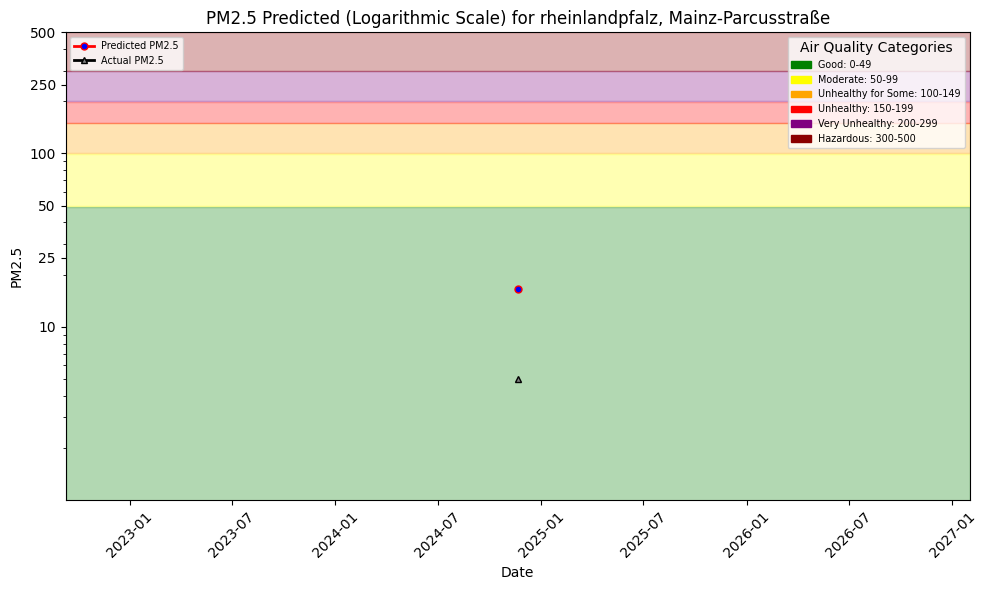

In [29]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---